Pieces found: 4
Grid: 2 x 2
Improving layout...


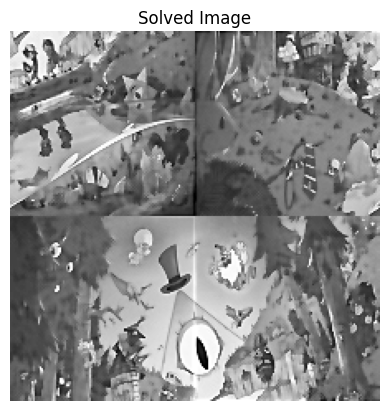

In [9]:
import cv2
import numpy as np
import os
import math
import matplotlib.pyplot as plt

# -----------------------------
# SETTINGS
# -----------------------------
FOLDER = "data/enhanced_pieces/2x2/2"
EDGE_WIDTH = 6
GRID_AUTO = True
SWAP_ITERS = 3000

# -----------------------------
# LOAD IMAGES
# -----------------------------
def load_images(folder):
    imgs = []
    for f in sorted(os.listdir(folder)):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(os.path.join(folder, f))
            imgs.append(img)
    return imgs

pieces = load_images(FOLDER)
n = len(pieces)

print("Pieces found:", n)

if n == 0:
    raise Exception("No images found in folder.")

# Resize all to same size
h, w = pieces[0].shape[:2]
pieces = [cv2.resize(p, (w, h)) for p in pieces]

# -----------------------------
# AUTO GRID SIZE
# -----------------------------
grid_size = int(math.sqrt(n))
assert grid_size * grid_size == n, "Number of pieces must be perfect square"
rows = cols = grid_size
print("Grid:", rows, "x", cols)

# -----------------------------
# EDGE NORMALIZATION
# -----------------------------
def normalize_edge(e):
    e = e.astype(np.float32)
    return (e - np.mean(e)) / (np.std(e) + 1e-6)

# -----------------------------
# EDGE EXTRACTION
# -----------------------------
def extract_edges(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    top    = normalize_edge(lab[0:EDGE_WIDTH, :, :])
    bottom = normalize_edge(lab[-EDGE_WIDTH:, :, :])
    left   = normalize_edge(lab[:, 0:EDGE_WIDTH, :])
    right  = normalize_edge(lab[:, -EDGE_WIDTH:, :])

    return {
        'top': top,
        'bottom': bottom,
        'left': left,
        'right': right
    }

edges = [extract_edges(p) for p in pieces]

# -----------------------------
# EDGE MATCH FUNCTION
# -----------------------------
def edge_score(a, b):
    b = np.flip(b, axis=1)

    # Color difference
    color = np.mean((a - b) ** 2)

    # Gradient difference
    ga = cv2.Sobel(a, cv2.CV_32F, 1, 0, ksize=3)
    gb = cv2.Sobel(b, cv2.CV_32F, 1, 0, ksize=3)
    grad = np.mean((ga - gb) ** 2)

    return 0.7 * color + 0.3 * grad

rotate = {
    "top": "bottom",
    "bottom": "top",
    "left": "right",
    "right": "left"
}

# -----------------------------
# COMPATIBILITY MATRIX
# -----------------------------
scores = {}

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        for side in rotate:
            s = edge_score(edges[i][side], edges[j][rotate[side]])
            scores[(i, j, side)] = s

# -----------------------------
# FIND BEST PAIR
# -----------------------------
best_pair = None
best_score = float('inf')

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        for side in rotate:
            s = scores[(i,j,side)]
            if s < best_score:
                best_score = s
                best_pair = (i, j, side)

# -----------------------------
# GREEDY SOLVER
# -----------------------------
grid = -np.ones((rows, cols), dtype=int)
used = set()

dirs = {
    "top":    (-1, 0),
    "bottom": ( 1, 0),
    "left":   ( 0,-1),
    "right":  ( 0, 1)
}

# Place best pair at center
# SAFE SEED PLACEMENT (search for valid position)
i, j, side = best_pair
dr, dc = dirs[side]

placed = False

for r in range(rows):
    for c in range(cols):
        rr = r + dr
        cc = c + dc
        if 0 <= rr < rows and 0 <= cc < cols:
            grid[r, c] = i
            grid[rr, cc] = j
            used.add(i)
            used.add(j)
            placed = True
            break
    if placed:
        break

if not placed:
    raise RuntimeError("No valid place to seed initial pair")


# Match function
def find_best_match(idx, side):
    best = None
    best_score = float('inf')
    for j in range(n):
        if j in used: 
            continue
        s = scores[(idx, j, side)]
        if s < best_score:
            best_score = s
            best = j
    return best

# Greedy growth
changed = True
while changed:
    changed = False
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == -1:
                continue
            piece = grid[r][c]
            for side, (dr, dc) in dirs.items():
                rr, cc = r + dr, c + dc
                if 0 <= rr < rows and 0 <= cc < cols and grid[rr][cc] == -1:
                    match = find_best_match(piece, side)
                    if match is not None:
                        grid[rr][cc] = match
                        used.add(match)
                        changed = True

# -----------------------------
# COST FUNCTION
# -----------------------------
def total_cost(grid):
    cost = 0
    for r in range(rows):
        for c in range(cols):
            i = grid[r][c]
            if r+1 < rows:
                j = grid[r+1][c]
                cost += scores[(i,j,'bottom')]
            if c+1 < cols:
                j = grid[r][c+1]
                cost += scores[(i,j,'right')]
    return cost

# -----------------------------
# SWAP OPTIMIZATION
# -----------------------------
print("Improving layout...")
for _ in range(SWAP_ITERS):
    r1,c1 = np.random.randint(0,rows), np.random.randint(0,cols)
    r2,c2 = np.random.randint(0,rows), np.random.randint(0,cols)

    before = total_cost(grid)

    grid[r1,c1], grid[r2,c2] = grid[r2,c2], grid[r1,c1]

    after = total_cost(grid)
    if after > before:
        grid[r1,c1], grid[r2,c2] = grid[r2,c2], grid[r1,c1]

# -----------------------------
# BUILD FINAL IMAGE
# -----------------------------
final = np.zeros((rows * h, cols * w, 3), dtype=np.uint8)

for r in range(rows):
    for c in range(cols):
        final[r*h:(r+1)*h, c*w:(c+1)*w] = pieces[grid[r,c]]

# -----------------------------
# DISPLAY RESULT
# -----------------------------
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.title("Solved Image")
plt.axis("off")
plt.show()
